#Create toy data

We will create a simulation of brain waves. Such data might arise when when using multiple electrodes to record electrical brain waves over a period of time. Specifically, we are simulating two different conditions, each of which leads to a different pattern of wave propagation.


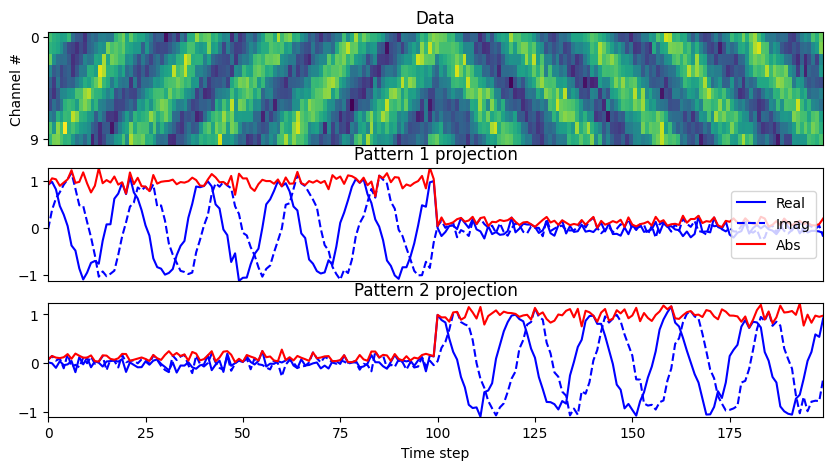

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 5 #trial length in seconds
fs = 20 #sampling rate in Hz
f = 1 #wave frequency in Hz
t = np.linspace(0,T,T*fs,endpoint=False)
wave = np.exp(1j*2*np.pi*f*t) #an oscillation in time
n_channels = 10
p1 = np.exp(1j*np.linspace(0,np.pi*2,n_channels,endpoint=False))    #Create phase delays across electrodes (pattern 1)
p2 = np.exp(1j*np.linspace(0,-np.pi*2,n_channels,endpoint=False))   #Create phase delays across electrodes (pattern 2)
p1 = p1/np.linalg.norm(p1)
p2 = p2/np.linalg.norm(p2)

data = np.vstack((np.outer(wave,p1),np.outer(wave,p2)))     #concatenate two different patterns of wave propagation into a single data set.
data = data + (np.random.randn(data.shape[0],data.shape[1]) + 1j*np.random.randn(data.shape[0],data.shape[1]))/10 #add complex-valued noise
labels = np.hstack((np.zeros(t.size),np.ones(t.size)))      #label samples for each condition as 0 and 1, respectively
inds_train = np.hstack((t<4,t<4))                           #define train indices corresponding to the first 80% of each condition
inds_test = ~inds_train                                     #define test indices corresponding to the last 20% of each condition

proj1 = data@p1.conj()                                      #project data onto p1. Remember to take p1's conjugate
proj2 = data@p2.conj()                                      #project data onto p1. Remember to take p2's conjugate

fig,axs = plt.subplots(3,1,figsize=[10,5]);

axs[0].imshow(data.real.T,aspect='auto');
axs[0].set_ylabel('Channel #');
axs[0].set_xticks([])
axs[0].set_yticks([0,n_channels-1])
axs[0].set_title('Data');
#axs[0].set_ylabel('Time step');
axs[1].plot(proj1.real,'b');                                #Plot the real component of proj1
axs[1].plot(proj1.imag,'b--');                              #Plot the imaginary component of proj1
axs[1].plot(np.abs(proj1),'r');                             #Plot the magnitude of proj1
axs[1].autoscale(enable=True, axis='both', tight=True)
axs[1].legend(['Real','Imag','Abs'],loc='right')
axs[1].set_xticks([])
axs[1].set_title('Pattern 1 projection');
axs[2].plot(proj2.real,'b');                                #Plot the real component of proj2
axs[2].plot(proj2.imag,'b--');                              #Plot the imaginary component of proj2
axs[2].plot(np.abs(proj2),'r');                             #Plot the magnitude of proj2
axs[2].autoscale(enable=True, axis='both', tight=True)
axs[2].set_xlabel('Time step');
axs[2].set_title('Pattern 2 projection');

# Install TIMBRE

Now, we will create a neural network (named TIMBRE) that learns multi-channel patterns in data that best predict the label associated with each sample.

In [ ]:
!git clone https://github.com/beatLaboratory/TIMBRE.git
!pip install -r TIMBRE/requirements.txt

# Run TIMBRE on simulated data

We will train the network. By defaut, the network has one node per class. Since there are two classes, there are two nodes.

In [7]:
from TIMBRE.TIMBRE import TIMBRE

m,fm,_ = TIMBRE(data,labels,inds_test,inds_train)                      #train neural network without hidden layer

#Examine performance

We will observe how the network's performance improves during training.

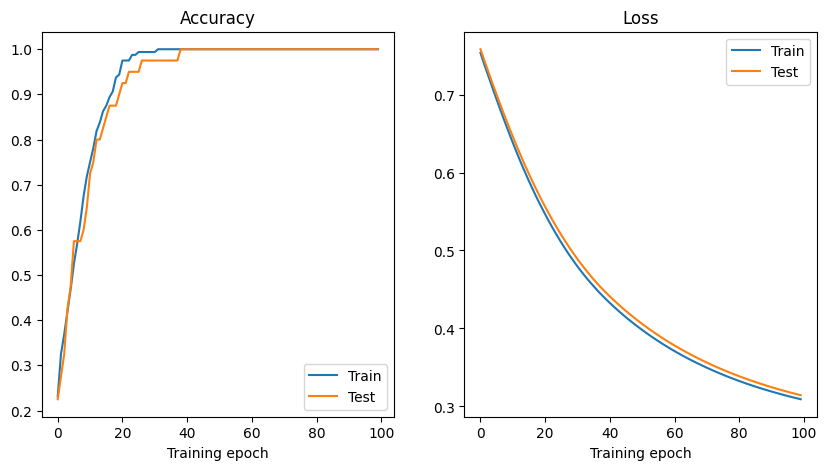

In [8]:
from TIMBRE.helpers import layer_output

fig,axs = plt.subplots(1,2,figsize=(10,5));
axs[0].plot(fm.history['accuracy']);
axs[0].plot(fm.history['val_accuracy']);
axs[0].legend(['Train','Test']);
axs[0].set_title('Accuracy');
axs[0].set_xlabel('Training epoch');
axs[1].plot(fm.history['loss']);
axs[1].plot(fm.history['val_loss']);
axs[1].legend(['Train','Test']);
axs[1].set_title('Loss');
axs[1].set_xlabel('Training epoch');

# Visualize network activity

Finally, we visualize the response of the trained model's layers to the input:
1.  **Complex-valued projection of the input.** Note that each of the two nodes learns one of the two patterns present in the data.
2.  **Amplitude of the projection.** This discards the phase of the projection, so we know how much of each pattern is present.
3.  **Softmax of the amplitude.** This converts the response to a probability distribution that sums to 1.

7/7 [==============================] - 0s 2ms/step


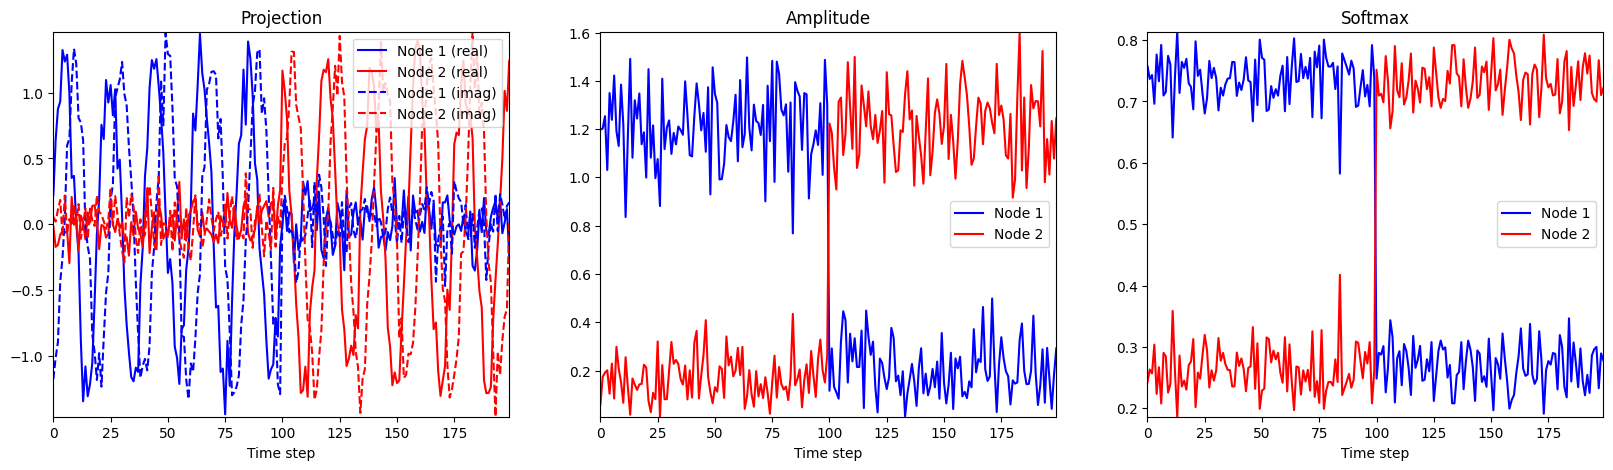

In [9]:
titles = ['Projection','Amplitude','Softmax','Softmax 2'];
fig1,axs1 = plt.subplots(1,len(m.layers),figsize=(20,5));
styles = ['b','r','b--','r--']
X = np.concatenate((np.real(data), np.imag(data)), axis = 1) #preprocess
for i in range(len(m.layers)): #plot the output of each layer in network
  pr = layer_output(data,m,i)
  for j in range(pr.shape[1]):
    axs1[i].plot(pr[:,j],styles[j]);
  axs1[i].set_title(titles[i]);
  axs1[i].set_xlabel('Time step');
  axs1[i].autoscale(enable=True, axis='both', tight=True);

axs1[0].legend(['Node 1 (real)','Node 2 (real)','Node 1 (imag)','Node 2 (imag)']);
axs1[1].legend(['Node 1','Node 2']);
axs1[2].legend(['Node 1','Node 2']);